# Actividad — **Transformers y BERT**

## Preparación del entorno

In [ ]:
# !pip install -q transformers datasets accelerate torch torchvision torchaudio

import torch, math, numpy as np, matplotlib.pyplot as plt
from transformers import (AutoTokenizer, AutoModel, AutoModelForMaskedLM,
                          AutoModelForSequenceClassification, pipeline)
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

PyTorch: 2.8.0+cu126
CUDA disponible: False


## Atención y Transformer

La **atención escalada producto punto** calcula la relevancia entre tokens:

$\text{Attention}(Q, K, V) = \mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$

## BERT como *Masked Language Model* (MLM)

Usaremos `dccuchile/bert-base-spanish-wwm-cased` para predecir palabras enmascaradas en español.

In [ ]:
model_name_mlm = "dccuchile/bert-base-spanish-wwm-cased"  # BERT en español
fill_mask = pipeline("fill-mask", model=model_name_mlm, tokenizer=model_name_mlm)

oraciones = [
    "El [MASK] persiguió al ratón toda la noche.",
    "La IA moderna se basa en el mecanismo de [MASK].",
    "El modelo BERT es un tipo de [MASK]."
]

for s in oraciones:
    print("\nEntrada:", s)
    for pred in fill_mask(s, top_k=5):
        print(f"  → {pred['sequence']}  (score={pred['score']:.3f})")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Device set to use cpu



Entrada: El [MASK] persiguió al ratón toda la noche.
  → El gato persiguió al ratón toda la noche.  (score=0.452)
  → El ratón persiguió al ratón toda la noche.  (score=0.062)
  → El lobo persiguió al ratón toda la noche.  (score=0.062)
  → El perro persiguió al ratón toda la noche.  (score=0.047)
  → El zorro persiguió al ratón toda la noche.  (score=0.027)

Entrada: La IA moderna se basa en el mecanismo de [MASK].
  → La IA moderna se basa en el mecanismo de.  (score=0.184)
  → La IA moderna se basa en el mecanismo de activación.  (score=0.040)
  → La IA moderna se basa en el mecanismo de transferencia.  (score=0.040)
  → La IA moderna se basa en el mecanismo de salto.  (score=0.021)
  → La IA moderna se basa en el mecanismo de control.  (score=0.016)

Entrada: El modelo BERT es un tipo de [MASK].
  → El modelo BERT es un tipo de modelo.  (score=0.112)
  → El modelo BERT es un tipo de motocicleta.  (score=0.073)
  → El modelo BERT es un tipo de vehículo.  (score=0.071)
  → El modelo

## Visualizar la **atención** en BERT

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


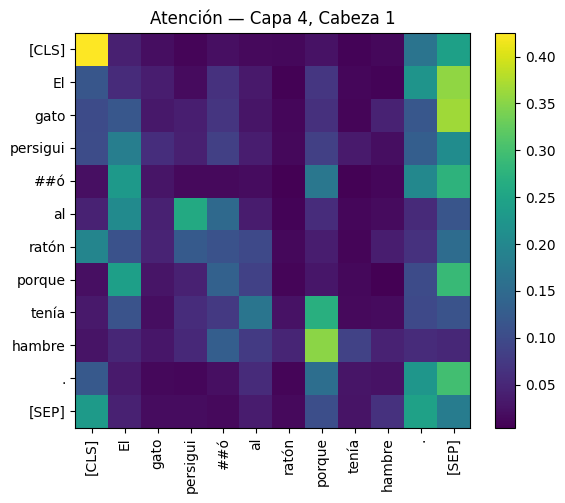

In [ ]:
import torch
import matplotlib.pyplot as plt

tok = AutoTokenizer.from_pretrained(model_name_mlm)
bert_enc = AutoModel.from_pretrained(model_name_mlm, output_attentions=True)

sent = "El gato persiguió al ratón porque tenía hambre."
enc = tok(sent, return_tensors="pt")
with torch.no_grad():
    out = bert_enc(**enc)
# out.attentions: list de [num_layers] con tensores (batch, heads, seq, seq)
atts = out.attentions

num_layers = len(atts)
num_heads = atts[0].shape[1]
layer_to_show = min(3, num_layers-1)   # tomar una capa intermedia
head_to_show  = 0

att = atts[layer_to_show][0, head_to_show].cpu().numpy()  # (seq, seq)
tokens = tok.convert_ids_to_tokens(enc["input_ids"][0])

plt.figure(figsize=(6, 5))
plt.imshow(att, interpolation="nearest")
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.title(f"Atención — Capa {layer_to_show+1}, Cabeza {head_to_show+1}")
plt.colorbar()
plt.tight_layout()
plt.show()

## Clasificación rápida con BERT (sentimientos)

Usamos un BERT multilingüe entrenado para *sentiment analysis* (`nlptown/bert-base-multilingual-uncased-sentiment`).

In [ ]:
model_name_cls = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment = pipeline("sentiment-analysis", model=model_name_cls, tokenizer=model_name_cls)

ejemplos = [
    "La película fue excelente, la recomiendo.",
    "El servicio fue terrible y la comida estaba fría.",
    "Está bien, pero no volvería pronto."
]

for t in ejemplos:
    print(t, "→", sentiment(t)[0])

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


La película fue excelente, la recomiendo. → {'label': '5 stars', 'score': 0.6492042541503906}
El servicio fue terrible y la comida estaba fría. → {'label': '1 star', 'score': 0.7573903799057007}
Está bien, pero no volvería pronto. → {'label': '3 stars', 'score': 0.722318708896637}



## **Resumen automático (Summarization)**

Usaremos un modelo *seq2seq* ya afinado para **resumir textos**. Para una demo en inglés utilizaremos `facebook/bart-large-cnn`


In [ ]:

from transformers import pipeline

# Modelo de resumen (inglés). Para español, reemplaza por un modelo finetuneado en es (p. ej., algún mT5).
model_name_sum = "facebook/bart-large-cnn"
summarizer = pipeline("summarization", model=model_name_sum)

texto_en = (
    "Artificial intelligence has seen rapid advances in recent years, with transformer-based architectures "
    "achieving state-of-the-art results across tasks such as language modeling, translation, and summarization. "
    "These models are trained on massive datasets and can generalize to a wide variety of inputs, but they also "
    "raise concerns related to bias, interpretability, and environmental impact due to their computational cost."
)

res = summarizer(texto_en, max_length=80, min_length=30, do_sample=False)
print("Resumen (EN):", res[0]["summary_text"])

# Ejemplo: si quieres probar con texto en español, puedes correr igualmente (la calidad puede variar):
texto_es = (
    "Los modelos Transformer han revolucionado el procesamiento del lenguaje natural al permitir el entrenamiento "
    "en paralelo y la captura de dependencias largas. Gracias a esta arquitectura, modelos como BERT y GPT han "
    "alcanzado resultados sobresalientes en múltiples tareas, aunque persisten desafíos como el sesgo y el alto costo computacional."
)

res_es = summarizer(texto_es, max_length=60, min_length=25, do_sample=False)
print("\nResumen (ES con BART inglés — calidad variable):", res_es[0]["summary_text"])


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Your max_length is set to 80, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Resumen (EN):  transformer-based architectures achieve state-of-the-art results across tasks such as language modeling, translation, and summarization. These models are trained on massive datasets and can generalize to a wide variety of inputs.

Resumen (ES con BART inglés — calidad variable): Los modelos Transformer han revolucionado el procesamiento del lenguaje natural. Los modelos BERT y GPT han alcanzado resultados sobresalientes en múltiples tareas.
